In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
# Generating synthetic dataset with 5 classes
X, Y = make_classification(n_samples=1000, n_features=3, n_informative=3, n_redundant=0, n_repeated=0, 
                           n_classes=5, n_clusters_per_class=1)

# One-hot encode the target labels
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Y.reshape(-1, 1))

In [3]:
# Splitting into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [4]:
class NeuralNetwork(object):
    def __init__(self):
        # Network architecture
        inputLayerNeurons = 3
        hiddenLayer1Neurons = 10
        hiddenLayer2Neurons = 8
        hiddenLayer3Neurons = 6
        outputLayerNeurons = 5  # 5 classes
        
        self.learning_rate = 0.05 # Optimizing learning rate
        
        # Initializing weights
        self.W_HI1 = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons)
        self.W_HI2 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.W_HI3 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons)
        self.W_OH = np.random.randn(hiddenLayer3Neurons, outputLayerNeurons)

    def sigmoid(self, x, der=False):
        if der:
            return x * (1 - x)
        else:
            return 1 / (1 + np.exp(-x))
        
    def softmax(self, x):
        # Ensuring x is a 2D array
        x = np.array(x)
        if len(x.shape) == 1:
            x = x.reshape(1, -1)  # Adding a batch dimension if it's missing
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def cross_entropy_loss(self, Y_true, Y_pred):
        # Avoiding log(0) by adding a small constant
        Y_pred = np.clip(Y_pred, 1e-12, 1.0)
        # Calculating cross-entropy loss
        return -np.sum(Y_true * np.log(Y_pred)) / Y_true.shape[0]

    def feedForward(self, X):
        # Ensuring X is a 2D array
        X = np.array(X)
        if len(X.shape) == 1:
            X = X.reshape(1, -1)  # Adding a batch dimension if it's missing

        # Hidden layers
        self.hidden_output1 = self.sigmoid(np.dot(X, self.W_HI1))
        self.hidden_output2 = self.sigmoid(np.dot(self.hidden_output1, self.W_HI2))
        self.hidden_output3 = self.sigmoid(np.dot(self.hidden_output2, self.W_HI3))

        # Output layer
        output_input = np.dot(self.hidden_output3, self.W_OH)
        pred = self.softmax(output_input)
        return pred

    def backPropagation(self, X, Y, pred):
        # Output layer error and delta
        output_error = Y - pred
        output_delta = self.learning_rate * output_error  # Softmax derivative handled implicitly
        
        # Hidden layers error and delta
        hidden_error3 = output_delta.dot(self.W_OH.T)
        hidden_delta3 = self.learning_rate * hidden_error3 * self.sigmoid(self.hidden_output3, der=True)
        
        hidden_error2 = hidden_delta3.dot(self.W_HI3.T)
        hidden_delta2 = self.learning_rate * hidden_error2 * self.sigmoid(self.hidden_output2, der=True)
        
        hidden_error1 = hidden_delta2.dot(self.W_HI2.T)
        hidden_delta1 = self.learning_rate * hidden_error1 * self.sigmoid(self.hidden_output1, der=True)
        
        # Updating weights
        self.W_HI1 += X.T.dot(hidden_delta1)
        self.W_HI2 += self.hidden_output1.T.dot(hidden_delta2)
        self.W_HI3 += self.hidden_output2.T.dot(hidden_delta3)
        self.W_OH += self.hidden_output3.T.dot(output_delta)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)

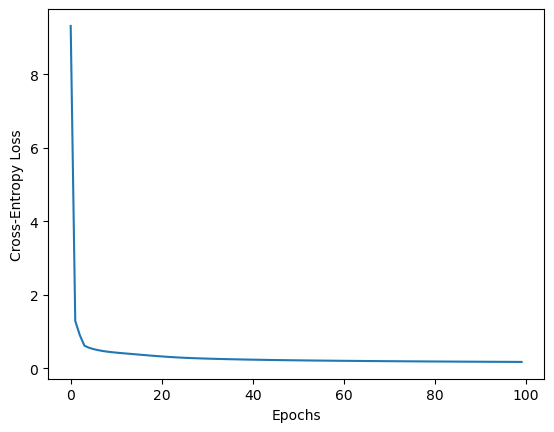

Accuracy: 91.00%
Loss: 17.17%


In [5]:
NN = NeuralNetwork()

# Training the model
err = []
epochs = 10000
for i in range(epochs):
    NN.train(X_train, Y_train)
    if i % 100 == 0:
        pred = NN.feedForward(X_train)
        loss = NN.cross_entropy_loss(Y_train, pred)
        err.append(loss)
        # print(f"Epoch {i}, Loss: {loss}")

# Plotting the loss over epochs
plt.plot(err)
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.show()

# Testing the model
test_predictions = NN.feedForward(X_test)
test_predictions = np.argmax(test_predictions, axis=1)
Y_test_labels = np.argmax(Y_test, axis=1)

# Calculating accuracy and loss
accuracy = np.mean(test_predictions == Y_test_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Loss: {loss * 100:.2f}%')

In [6]:
# Calculating Precision, Recall, and F1-Score for each class
precision = precision_score(Y_test_labels, test_predictions, average=None, zero_division=0)
recall = recall_score(Y_test_labels, test_predictions, average=None, zero_division=0)
f1 = f1_score(Y_test_labels, test_predictions, average=None, zero_division=0)

print(f'Precision per class: {precision}')
print(f'Recall per class: {recall}')
print(f'F1-Score per class: {f1}')

print(' ')

# Calculating Overall Precision, Recall, and F1-Score
precision = precision_score(Y_test_labels, test_predictions, average='weighted')
recall = recall_score(Y_test_labels, test_predictions, average='weighted')
f1 = f1_score(Y_test_labels, test_predictions, average='weighted')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

Precision per class: [0.85714286 0.94444444 0.92857143 0.88888889 0.93877551]
Recall per class: [0.92307692 0.89473684 0.83870968 0.93023256 0.93877551]
F1-Score per class: [0.88888889 0.91891892 0.88135593 0.90909091 0.93877551]
 
Precision: 91.16%
Recall: 91.00%
F1 Score: 91.00%


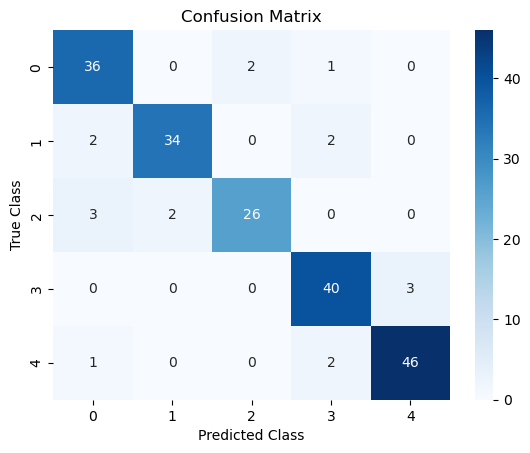

In [7]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_test_labels, test_predictions)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [8]:
# Code Description

"""
All necessary libraries are imported which are used throughout the project. A synthetic dataset of 1000 samples with 5 distinct
classes is generated using `make_classification` library. The `OneHotEncoder` is used to transform the class labels into a format
suitable for multi-class classification. The dataset is then divided in train and test in 80-20 proportion. The neural network's
architecture is modified to include three hidden layers, each using the sigmoid activation function, while the output layer 
uses softmax to convert predictions into class probabilities. Cross-entropy loss is implemented to calculate the error. During
backpropagation, the network's weights were updated by computing the gradients layer-by-layer. The model was trained for 10,000 
epochs with a learning rate of 0.05.  Precision, recall, and F1-scores were calculated, indicating the model's performance 
across all classes and the confusion matrix provided additional insight into the network’s predictions, helping to identify any
misclassifications.

"""

# Discussion

"""
The dataset is generated with five distinct classes and the network architecture was expanded to include three hidden layers.
The output layer is modified to have five neurons to represent one of the classes. A key addition to the model is the use of
the softmax activation function in the output layer, which converts the raw output values into class probabilities. The
backpropagation algorithm is also adapted to handle multi-class classification by implementing cross-entropy loss, which is
more appropriate for this type of problem than mean squared error. Additionally, the learning rate was tuned through
experimentation. A learning rate of 0.05 yielded the best performance, with a final loss of around 20%. Finding the right
learning rate through trial and error was a challenge, but ultimately helped improve the stability and convergence of the model.

After training for 10,000 epochs, the final loss was around 20%, with an accuracy of around 90%. The precision, recall, and 
F1-score were calculated for each of the five classes and each value was observed to surpass 85%. These metrics indicate that
the network was performing well across all classes, with no significant class imbalance or misrepresentation. By tuning the
number of neurons in each hidden layer, the network was able to learn more intricate patterns in the data, leading to better
accuracy. Upon performance comparison, changing either the learning rate value or the hidden layer neurons' values significantly
impacted the results.

The project is successfully implemented a three-hidden-layer neural network for multi-class classification. Potential
improvements could involve exploring different activation functions in the hidden layers to improve convergence rates or 
experimenting with more advanced optimization techniques. Additionally, increasing the dataset size or adding more informative
features could further enhance the network’s generalization capabilities. It can easily be outlined that fine-tuning model 
architectures and hyperparameters to achieve optimal performance in multi-class classification tasks is important.

"""

"\nThe dataset is generated with five distinct classes and the network architecture was expanded to include three hidden layers.\nThe output layer is modified to have five neurons to represent one of the classes. A key addition to the model is the use of\nthe softmax activation function in the output layer, which converts the raw output values into class probabilities. The\nbackpropagation algorithm is also adapted to handle multi-class classification by implementing cross-entropy loss, which is\nmore appropriate for this type of problem than mean squared error. Additionally, the learning rate was tuned through\nexperimentation. A learning rate of 0.05 yielded the best performance, with a final loss of around 20%. Finding the right\nlearning rate through trial and error was a challenge, but ultimately helped improve the stability and convergence of the model.\n\nAfter training for 10,000 epochs, the final loss was around 20%, with an accuracy of around 90%. The precision, recall, and \